# Transfer learning with MobileNetv2

# Imports

In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader, ConcatDataset 

import torchvision

from torchvision.transforms import v2

from pathlib import Path

from matplotlib import pyplot as plt

from PIL import Image

import pandas as pd

import time

import multiprocessing

# Functions

In [29]:
def prepare_and_get_data_path(where_is_running: str = 'colab') -> Path:
    match where_is_running:
        case 'colab':
            from google.colab import userdata
            import os

            kaggle_target_path = Path('/root/.kaggle/kaggle.json')

            kaggle_target_path.parent.mkdir(exist_ok=True, parents=True)

            with open(kaggle_target_path, 'w') as f:
                f.write(userdata.get('Kaggle'))

            os.system('kaggle datasets download -d marquis03/fruits-100')
            os.system('unzip -q fruits-100.zip -d fruits-100')
            os.system('rm -r fruits-100.zip')

            data_path = Path('fruits-100')

        case 'pc':
            data_path = Path(
                '/home/ramin/ramin_programs/files/datasets/fruits-100')

        case _:
            data_path = Path('fruits-100')

    return data_path


def find_device():
    device = 'cpu'

    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'

    return device


def load_train_data(data_path: Path) -> DataLoader:
    tr = v2.Compose([
        v2.Resize([90, 160]),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True), ]
    )

    tr_augmented = v2.Compose(
        [v2.RandomHorizontalFlip(),
         v2.RandomVerticalFlip(),
         v2.RandomZoomOut(),
         v2.Resize([90, 160]),
         v2.ToImage(),
         v2.ToDtype(torch.float32, scale=True), ]
    )

    image_folder = torchvision.datasets.ImageFolder(data_path, transform=tr)

    image_folder_augmented = torchvision.datasets.ImageFolder(
        data_path, transform=tr_augmented)

    both_d = ConcatDataset([image_folder, image_folder_augmented])

    data_loader = DataLoader(
        both_d, batch_size=32, shuffle=True, num_workers=multiprocessing.cpu_count())

    return data_loader


def load_valid_data(data_path: Path) -> DataLoader:
    tr = v2.Compose([
        v2.Resize([90, 160]),
        v2.ToImage(),
        v2.ToDtype(torch.float32, True), ]
    )

    valid_image_folder = torchvision.datasets.ImageFolder(
        data_path, transform=tr)

    val_data_loader = DataLoader(
        valid_image_folder, batch_size=32, shuffle=True)

    return val_data_loader


def load_model(device: str = 'cuda') -> nn.Module:
    model = torchvision.models.mobilenet_v2(
        weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False

    model.classifier[1] = nn.Linear(1280, 100)
    model = model.to(device)

    return model


def train(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer,
          device: str = 'cuda', tensorboard_writer=None, epoch: int = 0) -> list[float]:
    model = model.to(device)
    model.train()

    running_loss = 0
    i_c = 0
    number_of_batches = len(data_loader)

    losses = []

    t1 = time.time()
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        prediction = model(images)
        loss = loss_fn(prediction, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i_c += 1
        if (i % 10 == 9) or i == number_of_batches - 1:
            time_taken = time.time() - t1
            remaining_time = (time_taken / i_c) * (number_of_batches - i)
            remaining_minutes = int(remaining_time // 60)
            remaining_seconds = int(remaining_time % 60)
            print(
                f'\r{i + 1}/{number_of_batches}, loss = {loss.item()
                                                                   :>4f}, time_taken: {time_taken:.2f}'
                f', predicting_remaining_time: {
                    remaining_minutes:d}m {remaining_seconds:02d}s',
                end='')
            if tensorboard_writer:
                tensorboard_writer.add_scalar(
                    'training loss', running_loss / i_c, epoch * number_of_batches + i)
            losses.append(running_loss / i_c)
            running_loss = 0
            i_c = 0
            t1 = time.time()
    print()

    return losses


def evaluate(model: nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: nn.Module,
             device: str = 'cuda') -> tuple[torch.float, torch.float]:
    model = model.to(device)
    model.eval()

    data_size = len(data_loader.dataset)
    number_of_batches = len(data_loader)

    i_c = 0

    loss = 0
    correct = 0
    with torch.no_grad():
        t1 = time.time()
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device)

            prediction = model(images)
            loss += loss_fn(prediction, labels).item()
            correct += (prediction.argmax(1) ==
                        labels).type(torch.float).sum().item()

            i_c += 1
            if (i % 10 == 9) or i == number_of_batches - 1:
                time_taken = time.time() - t1
                remaining_time = (time_taken / i_c) * (number_of_batches - i)
                remaining_minutes = int(remaining_time // 60)
                remaining_seconds = int(remaining_time % 60)
                print(f'\r{i + 1}/{number_of_batches}, time_taken: {time_taken:.2f}'
                      f', predicting_remaining_time: {
                          remaining_minutes:d}m {remaining_seconds:02d}s',
                      end='')
                i_c = 0
                t1 = time.time()

        loss /= number_of_batches
        correct /= data_size
    
    print()

    return correct, loss


def predict(model: nn.Module,
            test_data_path: Path,
            device: str = 'cuda') -> pd.DataFrame:
    model = model.to(device)
    model.eval()

    tr = v2.Compose(
        [v2.Resize([90, 160]),
         v2.ToImage(),
         v2.ToDtype(torch.float32, True), ]
    )

    image_paths = test_data_path.rglob('*.jpg')

    result = {'image_path': [], 'prediction': []}

    with torch.no_grad():
        for image_path in image_paths:
            image = Image.open(image_path)

            image_tensor = tr(image).to(device)
            image_tensor = image_tensor.unsqueeze(0)

            with torch.no_grad():
                prediction = model(image_tensor)
            prediction = torch.argmax(prediction)

            result['image_path'].append(
                f'{image_path.parent.name} / f{image_path.name}')
            result['prediction'].append(prediction.detach().cpu().numpy())

    return pd.DataFrame(result)

# TensorBoard

In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fruits_100')

In [15]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 13293), started 0:05:02 ago. (Use '!kill 13293' to kill it.)

# Device

In [6]:
device = find_device()

print(f'device: {device}')

device: cuda


# Data

In [7]:
data_path = prepare_and_get_data_path('pc')

In [8]:
train_data_loader = load_train_data(data_path/'train')
valid_data_loader = load_valid_data(data_path/'val')

tensor(47)


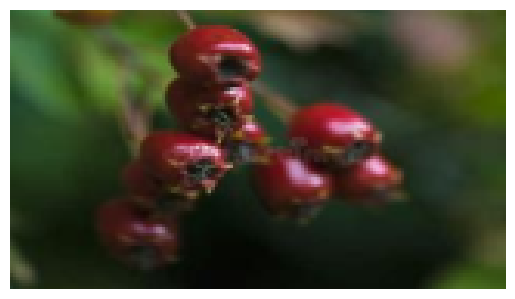

In [9]:
for tensor_image, label in train_data_loader:
    figure, axes = plt.subplots(1,1)

    axes.imshow(torchvision.transforms.ToPILImage()(tensor_image[0]))
    axes.set_axis_off()
    print(label[0])
    break

# Model

In [11]:
model = load_model(device)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train

In [28]:
losses = []

train_accuracies = []
train_losses = []

valid_accuracies = []
valid_losses = []

for epoch in range(2):
    print(f'in epoch: {epoch}')
    l1 = train(model, train_data_loader, loss_fn,
               optimizer, device, writer, epoch)
    losses += l1

    accuracy, loss = evaluate(model, train_data_loader, loss_fn, device)
    print(f'train -> accuracy: {accuracy:.2f}, loss: {loss:.2f}')

    train_accuracies.append(accuracy)
    train_losses.append(loss)

    accuracy, loss = evaluate(model, valid_data_loader, loss_fn, device)
    print(f'validation -> accuracy: {accuracy:.2f}, loss: {loss:.2f}')

    valid_accuracies.append(accuracy)
    valid_losses.append(loss)

in epoch: 0


50/2500, loss = 2.849459, time_taken: 1.50, predicting_remaining_time: 6m 08s
50/2500, time_taken: 1.37, predicting_remaining_time: 5m 35strain -> accuracy: 0.01, loss: 0.05
50/157, time_taken: 2.51, predicting_remaining_time: 0m 27svalidation -> accuracy: 0.15, loss: 0.69
in epoch: 1
50/2500, loss = 2.774327, time_taken: 1.51, predicting_remaining_time: 6m 09s
50/2500, time_taken: 1.46, predicting_remaining_time: 5m 58strain -> accuracy: 0.01, loss: 0.05
50/157, time_taken: 2.27, predicting_remaining_time: 0m 24svalidation -> accuracy: 0.14, loss: 0.72


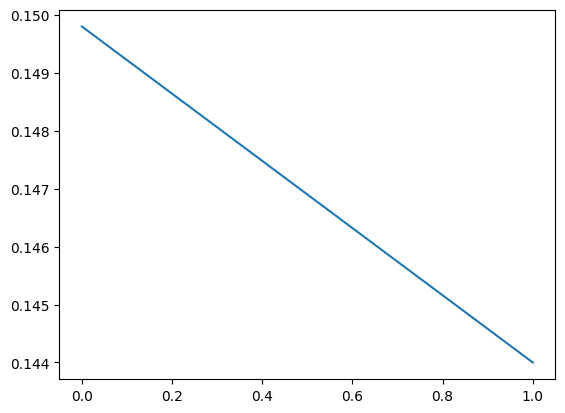

In [30]:
plt.plot(valid_accuracies)

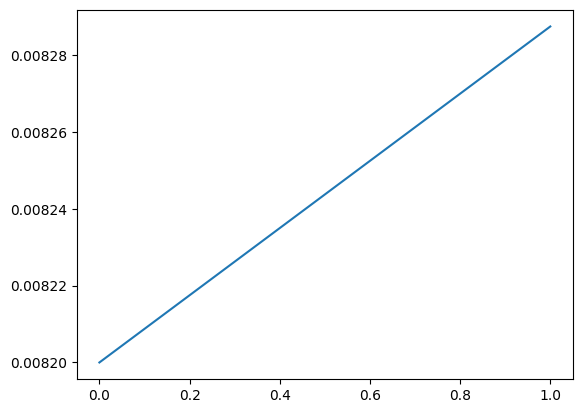

In [31]:
plt.plot(train_accuracies)

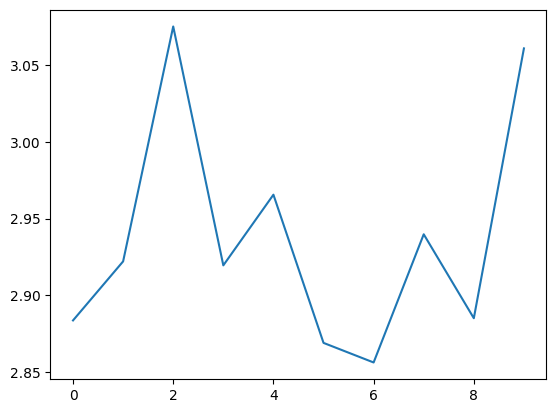

In [21]:
plt.plot(losses)

# Test

In [ ]:
result = predict(model, data_path/'test', device=device)

In [ ]:
result